module paper
https://arxiv.org/pdf/1709.01507.pdf

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from keras.layers import Activation, Reshape, Permute, multiply, MaxPooling2D, AveragePooling2D
import keras.backend as K
from sklearn.model_selection import train_test_split
import albumentations as albu
from albumentations import (HorizontalFlip, ShiftScaleRotate, GridDistortion)
import matplotlib.pyplot as plt

Squeeze and Excitation block

In [2]:
def SEBlock(ratio=16,activation='relu',kernel_initializer='he_normal',channelindex=-1):

  def enter(tensor):
    num_filters=tensor.shape[channelindex]
    
    SE_shape=(1,1,num_filters)
    se=GlobalAveragePooling2D()(tensor)
    se=Dense(num_filters//ratio,activation=activation,kernel_initializer=kernel_initializer,use_bias=False)(se)
    se=Dense(num_filters,activation="sigmoid",kernel_initializer=kernel_initializer,use_bias=False)(se)
    if channelindex==1:
      se = Permute((3, 1, 2))(se)
    x = multiply([tensor, se])
    return x
  return   enter


convolution => batch normalization => activation block

In [3]:
def conv_bn_act(filters=32,stride=1,kernal_size=(1,1)):
  def enter(input_x):
    x = Conv2D(filters = filters, kernel_size = kernal_size, strides = (stride, stride), kernel_initializer="he_normal")(input_x)
    x = BatchNormalization()(x)
    x = Activation(tf.keras.layers.LeakyReLU())(x)
    return x
  return enter

dense => batch normalization => activation block

In [4]:
def fs_bn_act(units=32):
    def enter(input_x):
      x = Dense(units,kernel_initializer="he_normal")(input_x)
      x = BatchNormalization()(x)
      x = Activation(tf.keras.layers.LeakyReLU())(x)
      return x
    return enter  

create model with with Squeeze and Excitation blocks

In [5]:
def createModelWithSE(input_shape = (32,32,3), output_units = 10):
  input_layer = keras.layers.Input(shape = input_shape)
  x = conv_bn_act(filters=64)(input_layer)
  x = SEBlock()(x) 
  x = conv_bn_act(filters=64)(x)
  x = SEBlock()(x) 
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = conv_bn_act(filters=32)(x)
  x = SEBlock()(x) 
  x = conv_bn_act(filters=32)(x)
  x = SEBlock()(x) 
  x = Dropout(0.25)(x)
  x = GlobalAveragePooling2D()(x)
  x = fs_bn_act(units=256)(x)
  x = Dropout(0.25)(x)
  x = fs_bn_act(units=128)(x)
  x = Dropout(0.25)(x)
  output_layer = Dense(units = output_units, activation="softmax", kernel_initializer="he_normal")(x)
  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model

create model with without Squeeze and Excitation blocks

In [6]:
def createModel(input_shape = (32,32,3), output_units = 10):
  input_layer = keras.layers.Input(shape = input_shape)
  x = conv_bn_act(filters=64)(input_layer)
  x = conv_bn_act(filters=64)(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = conv_bn_act(filters=32)(x)
  x = conv_bn_act(filters=32)(x)
  x = Dropout(0.25)(x)
  x = GlobalAveragePooling2D()(x)
  x = fs_bn_act(units=256)(x)
  x = Dropout(0.25)(x)
  x = fs_bn_act(units=128)(x)
  x = Dropout(0.25)(x)
  output_layer = Dense(units = output_units, activation="softmax", kernel_initializer="he_normal")(x)
  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model

In [7]:
modelWithSE=createModelWithSE()
modelWithSE.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'],  loss= "categorical_crossentropy")
modelWithSE.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   256         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

In [8]:
modelWithoutSE=createModel()
modelWithoutSE.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'],  loss= "categorical_crossentropy")
modelWithoutSE.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        256       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        4160      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                           

In [16]:
def display_training_result(history):

  plt.figure(figsize=(16,12))

  plt.subplot(2,1,1)
  plt.plot(history.history['loss'], label = 'train_loss', color = 'g')
  plt.plot(history.history['val_loss'], label = 'valid_loss', color = 'r')
  plt.title('training/validation loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()

  plt.subplot(2,1,2)
  plt.plot(history.history['accuracy'], label = 'train_acc', color = 'g')
  plt.plot(history.history['val_accuracy'], label = 'valid_acc', color = 'r')
  plt.title('training/validation accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()

  plt.show()

load dataset

In [10]:
#Load cifar10 data
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()
train_y = keras.utils.to_categorical(train_y, 10)
test_y = keras.utils.to_categorical(test_y, 10)


x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.25)

170498071/170498071 [==============================] - 4s 0us/step


make image augmentation

In [11]:
def input_generator(x,y,aug,batch_size=64):

  x_len = len(x)
  batch_x, batch_y = [],[]
  while True:

    batch_indices = np.random.choice(x_len, size = batch_size)
    
    for idx in batch_indices:
      batch_y.append(y[idx])
      batch_x.append(aug(image = x[idx])['image']/255.0)

    batch_x, batch_y = np.stack(batch_x), np.stack(batch_y)
    yield batch_x, batch_y
    batch_x, batch_y = [],[]
  
aug_for_train = albu.Compose([HorizontalFlip(p=0.5),
                              ShiftScaleRotate(shift_limit=0.1,scale_limit=0.25,rotate_limit=20,p=0.5),
                              GridDistortion(p=0.5)])
aug_for_valid = albu.Compose([])

train_gen = input_generator(x_train, y_train, aug_for_train)
valid_gen = input_generator(x_val, y_val, aug_for_valid)

In [12]:
modelWithSE_history =modelWithSE.fit_generator(train_gen,epochs= 20,validation_data=valid_gen,steps_per_epoch = len(x_train) // 64,
validation_steps = len(x_val) // 64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
585/585 [==============================] - 33s 35ms/step - loss: 1.9741 - accuracy: 0.2828 - val_loss: 1.8144 - val_accuracy: 0.3272
Epoch 2/20
585/585 [==============================] - 20s 35ms/step - loss: 1.8165 - accuracy: 0.3361 - val_loss: 1.7106 - val_accuracy: 0.3729
Epoch 3/20
585/585 [==============================] - 21s 36ms/step - loss: 1.7503 - accuracy: 0.3642 - val_loss: 1.6734 - val_accuracy: 0.3923
Epoch 4/20
585/585 [==============================] - 20s 34ms/step - loss: 1.7068 - accuracy: 0.3792 - val_loss: 1.6647 - val_accuracy: 0.4006
Epoch 5/20
585/585 [==============================] - 20s 34ms/step - loss: 1.6514 - accuracy: 0.3978 - val_loss: 1.6089 - val_accuracy: 0.4191
Epoch 6/20
585/585 [==============================] - 21s 36ms/step - loss: 1.6487 - accuracy: 0.4037 - val_loss: 1.5644 - val_accuracy: 0.4329
Epoch 7/20
585/585 [==============================] - 20s 35ms/step - loss: 1.6198 - accuracy: 0.4146 - val_loss: 1.5339 - val_accuracy:

In [13]:
modelWithoutSE_history =modelWithoutSE.fit_generator(train_gen,epochs= 20,validation_data=valid_gen,steps_per_epoch = len(x_train) // 64,
validation_steps = len(x_val) // 64)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


585/585 [==============================] - 21s 34ms/step - loss: 1.9845 - accuracy: 0.2834 - val_loss: 1.8258 - val_accuracy: 0.3270
Epoch 2/20
585/585 [==============================] - 19s 32ms/step - loss: 1.8194 - accuracy: 0.3295 - val_loss: 1.7950 - val_accuracy: 0.3483
Epoch 3/20
585/585 [==============================] - 19s 32ms/step - loss: 1.7591 - accuracy: 0.3590 - val_loss: 1.6550 - val_accuracy: 0.4074
Epoch 4/20
585/585 [==============================] - 18s 32ms/step - loss: 1.7182 - accuracy: 0.3748 - val_loss: 1.6699 - val_accuracy: 0.3904
Epoch 5/20
585/585 [==============================] - 18s 32ms/step - loss: 1.6975 - accuracy: 0.3828 - val_loss: 1.6360 - val_accuracy: 0.4077
Epoch 6/20
585/585 [==============================] - 19s 32ms/step - loss: 1.6764 - accuracy: 0.3921 - val_loss: 1.6484 - val_accuracy: 0.4009
Epoch 7/20
585/585 [==============================] - 19s 32ms/step - loss: 1.6699 - accuracy: 0.3941 - val_loss: 1.6357 - val_accuracy: 0.4010
Epo

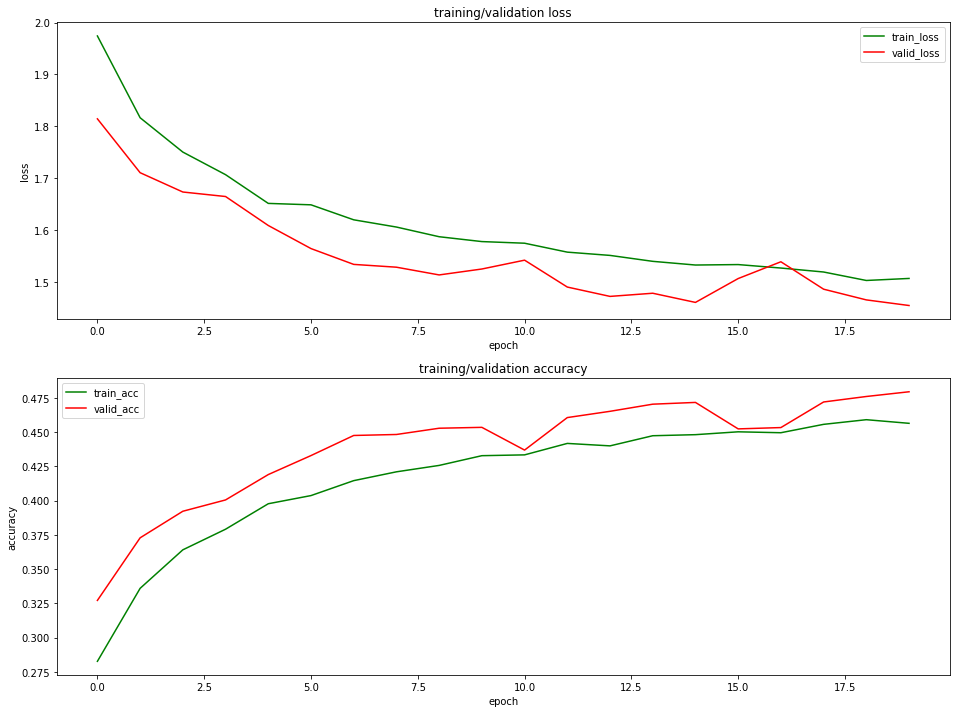

In [17]:
display_training_result(modelWithSE_history)


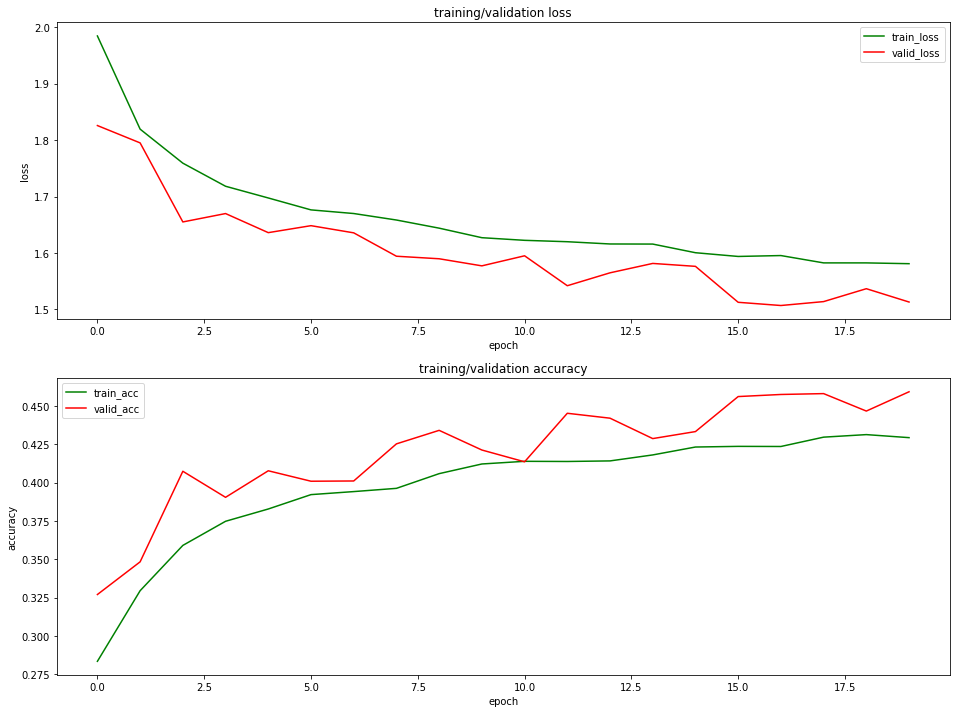

In [18]:
display_training_result(modelWithoutSE_history)


In [19]:
modelWithoutSE_scores = modelWithoutSE.evaluate(x=test_x/255.0, y=test_y)
modelWithSE_scores = modelWithSE.evaluate(x=test_x/255.0, y=test_y)

313/313 [==============================] - 1s 5ms/step - loss: 1.4633 - accuracy: 0.4744


In [20]:
print(f' Regular CNN :  loss {modelWithoutSE_scores[0]}, accuracy {modelWithoutSE_scores[1]}')
print(f' SE CNN : loss {modelWithSE_scores[0]}, accruacy {modelWithSE_scores[1]}')

 Regular CNN :  loss 1.5165108442306519, accuracy 0.45320001244544983
 SE CNN : loss 1.4633188247680664, accruacy 0.47440001368522644
